In [15]:
%matplotlib inline

import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
glob.glob('/home/ngr4/scratch60/scnd/*csv')

['/home/ngr4/scratch60/scnd/monocole_traj-umapcoords.csv']

In [3]:
df = pd.read_csv('/home/ngr4/scratch60/scnd/monocole_traj-umapcoords.csv', index_col=0)
df.columns = ['Pseudotime', 'UMAP 1', 'UMAP 2']


Text(0.5, 0, 'UMAP 1')

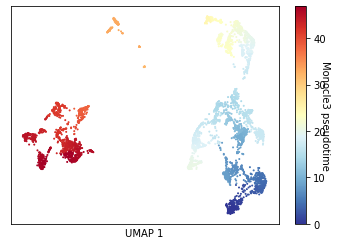

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.scatter(df['UMAP 1'], df['UMAP 2'], c=df['Pseudotime'], cmap='RdYlBu_r', s=1)
cbar = fig.colorbar(im)
cbar.set_label('Monocle3 pseudotime', rotation=270)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')

In [5]:
# load metadata 
dt = pd.read_csv(os.path.join('/home/ngr4/scratch60/scnd/data/processed/', 'astrocytes_cellmd.csv'))

In [7]:

cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

In [12]:
# check correlation 
df = df.reset_index()
dt = dt.merge(df, left_index=True, right_index=True)

(4090, 3) (4090, 19)


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


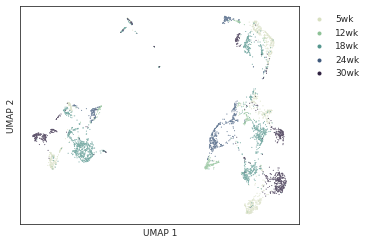

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(df['UMAP 1'], df['UMAP 2'], hue=dt['timepoint'], palette=cmap_wt, s=1, rasterized=True, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.legend(bbox_to_anchor=(1.01, 1))
fig.savefig('/home/ngr4/project/scnd/results/monocle_umap_bytimepoint.pdf', bbox_inches='tight', dpi=600)

In [10]:
import math
import numpy as np

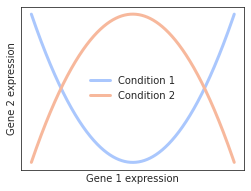

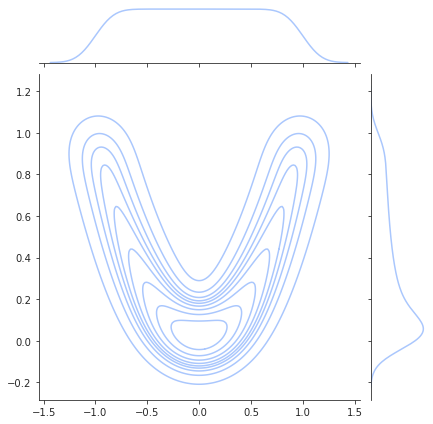

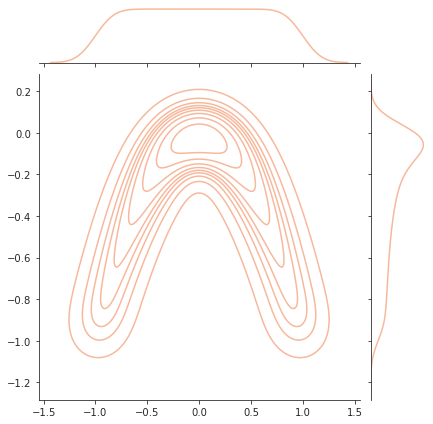

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
x = np.linspace(-1, 1, 1000)
y1 = x**2
y2 = -1*x**2

ax.plot(x, y1-0.5, label='Condition 1', linewidth=3, color=sns.color_palette('coolwarm', 2)[0])
ax.plot(x, y2+0.5, label='Condition 2', linewidth=3, color=sns.color_palette('coolwarm', 2)[1])

ax.legend()
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Gene 1 expression')
ax.set_ylabel('Gene 2 expression')

# plot marginals
p1=sns.jointplot(x=x, y=y1, kind='kde', color=sns.color_palette('coolwarm', 2)[0])
p2=sns.jointplot(x=x, y=y2, kind='kde', color=sns.color_palette('coolwarm', 2)[1])

fig.savefig('/home/ngr4/project/toy_nonlinear_fail.pdf')
p1.savefig('/home/ngr4/project/toy_nonlinear_fail2.pdf')
p2.savefig('/home/ngr4/project/toy_nonlinear_fail3.pdf')

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

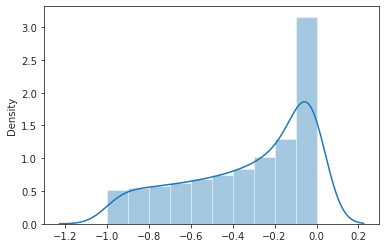

In [28]:
sns.distplot(y2)

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

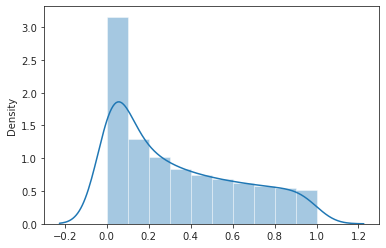

In [27]:
sns.distplot(y1)

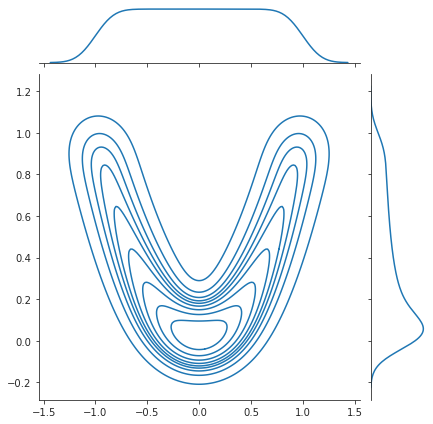

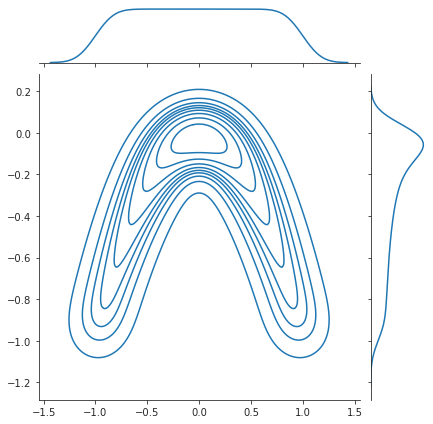

In [29]:
fig, ax = plt.subplots(1, 1, figsize=())
sns.jointplot(x=x, y=y1, kind='kde', color=)
sns.jointplot(x=x, y=y2, kind='kde'. color)